# Read and process soil water content sensors


location of soil sensors and their numbers											
						
|Port| Sensor No | Place| depth | mTAW |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|   1   |  37   |  1 | 70 |  
|   2   |  3    |  1 | 40 |  
|   4   |  28   |  1 | 20 |  
|   5   |  41   |  2 | 70 | 
|   7   |  29   |  2 | 20 | 
|   8   |  4  |  2 | 40 | 
|   10  |  x   |  3 | x |  
|   11  |  x   |  3 | x |  
|   12  |  x   |  3 | x | 


# Import Python modules

In [1]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)

# Read data file

In [36]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'RawData.csv')
Cal = pd.read_csv(file,sep=';', header=0)
print(Cal)

    SensorNumber   RawValue  KnownVWC  Unnamed: 3
0              7  27.192825     0.353         NaN
1              7  25.560288     0.254         NaN
2              7  23.913115     0.209         NaN
3             28  27.711502     0.353         NaN
4             28  26.337332     0.254         NaN
5             28  24.516957     0.209         NaN
6             41  28.118244     0.353         NaN
7             41  26.337332     0.254         NaN
8             41  24.753454     0.209         NaN
9             43  27.192825     0.353         NaN
10            43  25.218349     0.254         NaN
11            43  23.913115     0.209         NaN
12             3  28.418761     0.353         NaN
13             3  26.337332     0.254         NaN
14             3  25.446928     0.209         NaN
15            29  28.418761     0.353         NaN
16            29  25.673040     0.254         NaN
17            29  24.635553     0.209         NaN
18             4  28.617026     0.353         NaN


In [64]:
path2 = os.getcwd()
path = os.path.join(path2, 'Data_Callibration')
file = os.path.join(path, 'WeatherData.csv')

#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=';', parse_dates=[['date','time']],dayfirst=True)
#clim['date_time']=pd.to_datetime(clim['date_time'], unit='s')
clim2=clim.set_index('date_time')
climdaily=clim2.resample('D').agg({'precipitation': np.sum})#, 'air_temperature': np.mean,'rel_humidity': np.mean})
#climdaily.reset_index().plot(kind='scatter', x='date_time', y='precipitation')

print(climdaily)
climdaily.to_excel('saved_climfile.xlsx')


            precipitation
date_time                
2022-01-10            7.8
2022-01-11            3.0
2022-01-12            0.0
2022-01-13            0.0
2022-01-14            0.0
...                   ...
2022-12-06            0.0
2022-12-07            0.0
2022-12-08            0.0
2022-12-09            0.0
2022-12-10            0.0

[335 rows x 1 columns]


# Plot data

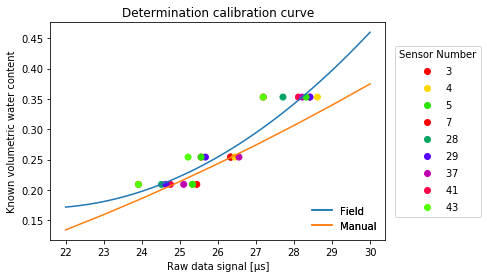

          2
0.003844 x - 0.1638 x + 1.916
0.8835858446749271


In [38]:
import seaborn as sns
from sklearn.metrics import r2_score
import scipy.stats as stats

x = Cal.RawValue
y = Cal.KnownVWC
colors = Cal.SensorNumber
xx = np.arange(22,31)
yy = 0.0007*xx**2 - 0.0063*xx - 0.0663


model = np.poly1d(np.polyfit(Cal['RawValue'],
                             Cal['KnownVWC'], 2))
polyline = np.linspace(22, 30, 100)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=colors, cmap='prism')
legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor = (1.30, 0.5), loc='center right', title="Sensor Number")
ax.add_artist(legend)
ax.set_ylabel('Known volumetric water content')
ax.set_xlabel('Raw data signal [µs]')
ax.set_title('Determination calibration curve')



field, = plt.plot(polyline, model(polyline))
manual, = plt.plot(xx,yy)


leg = ax.legend( handles = [field, manual], labels = ['Field', 'Manual'],
               loc='lower right', frameon=False)
ax.add_artist(leg);

plt.show()

  
print(model)
print(r2_score(Cal['KnownVWC'], 
               model(Cal['RawValue'])))
  

# Import field data

In [39]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'FieldData1.csv')
Field = pd.read_csv(file,sep=';', header=0)
Field1 = Field.iloc[:,0:20]
Data = Field1.iloc[:,[5,7,9,11,13,15,17,19]]
Data = Data.replace('NAN',np.nan)
Data = Data.fillna(0)
Data = Data.astype(float)
Data['PA_uS_Avg(7)'] = Data['PA_uS_Avg(7)'] + Data['PA_uS_Avg(3)']
Data['PA_uS_Avg(8)'] = Data['PA_uS_Avg(8)'] + Data['PA_uS_Avg(6)']
Data = Data.drop(['PA_uS_Avg(3)'], axis=1)
Data = Data.drop(['PA_uS_Avg(6)'], axis=1)
print(Data)

      PA_uS_Avg(1)  PA_uS_Avg(2)  PA_uS_Avg(4)  PA_uS_Avg(5)  PA_uS_Avg(7)  \
0            26.74         24.24          0.00          0.00         23.06   
1            27.16         26.50         25.39         25.83         25.49   
2            27.17         26.50         25.40         25.84         25.50   
3            27.18         26.50         25.40         25.84         25.50   
4            27.18         26.51         25.41         25.85         25.51   
...            ...           ...           ...           ...           ...   
2162         29.95         27.12         26.81         30.76         26.71   
2163         29.95         27.12         26.81         30.76         26.72   
2164         29.94         27.12         26.81         30.76         26.72   
2165         29.95         27.13         26.81         30.76         26.72   
2166         29.95         27.13         26.82         30.76         55.35   

      PA_uS_Avg(8)  
0             0.00  
1            26.90  


# Calculate volumetric water content

In [40]:
c=len(Data.columns) 
print(c)
r=len(Data)
print(r)
ColumnNumber = list(range(0, c))
print(ColumnNumber)
VWC = np.zeros((r,c))
print(VWC)

6
2167
[0, 1, 2, 3, 4, 5]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [41]:
for i in ColumnNumber:
    VWC[:,i] = 0.003844*Data.iloc[:,i]**2 - 0.1638*Data.iloc[:,i] + 1.916
print(VWC)

[[0.28455409 0.20413629 1.916      1.916      0.18287128 1.916     ]
 [0.30277857 0.274749   0.23516067 0.24972013 0.23833894 0.29133684]
 [0.30322901 0.274749   0.23547504 0.25006833 0.238661   0.2917673 ]
 ...
 [0.45760344 0.30098447 0.28749733 0.51461869 0.28372009 0.34175554]
 [0.45826761 0.30143184 0.28749733 0.51461869 0.28372009 0.34124359]
 [0.45826761 0.30143184 0.28792087 0.51461869 4.62623489 4.58185175]]


In [42]:
VWC[VWC>1] = np.nan
print(VWC)

[[0.28455409 0.20413629        nan        nan 0.18287128        nan]
 [0.30277857 0.274749   0.23516067 0.24972013 0.23833894 0.29133684]
 [0.30322901 0.274749   0.23547504 0.25006833 0.238661   0.2917673 ]
 ...
 [0.45760344 0.30098447 0.28749733 0.51461869 0.28372009 0.34175554]
 [0.45826761 0.30143184 0.28749733 0.51461869 0.28372009 0.34124359]
 [0.45826761 0.30143184 0.28792087 0.51461869        nan        nan]]


In [56]:
VWC = pd.DataFrame(VWC)
VWC.columns =['a70','a40','a20','b70','b20','b40']
print(VWC)

           a70       a40       a20       b70       b20       b40
0     0.284554  0.204136       NaN       NaN  0.182871       NaN
1     0.302779  0.274749  0.235161  0.249720  0.238339  0.291337
2     0.303229  0.274749  0.235475  0.250068  0.238661  0.291767
3     0.303680  0.274749  0.235475  0.250068  0.238661  0.291767
4     0.303680  0.275149  0.235790  0.250417  0.238984  0.291767
...        ...       ...       ...       ...       ...       ...
2162  0.458268  0.300984  0.287497  0.514619  0.283304  0.341244
2163  0.458268  0.300984  0.287497  0.514619  0.283720  0.341244
2164  0.457603  0.300984  0.287497  0.514619  0.283720  0.341756
2165  0.458268  0.301432  0.287497  0.514619  0.283720  0.341244
2166  0.458268  0.301432  0.287921  0.514619       NaN       NaN

[2167 rows x 6 columns]


In [57]:
Plotdata = Field1.iloc[:,0]
print(Plotdata)

0       2022-09-20 14:00:00
1       2022-09-20 14:30:00
2       2022-09-20 15:00:00
3       2022-09-20 15:30:00
4       2022-09-20 16:00:00
               ...         
2162    2022-11-04 15:00:00
2163    2022-11-04 15:30:00
2164    2022-11-04 16:00:00
2165    2022-11-04 16:30:00
2166    2022-11-04 17:00:00
Name: TIMESTAMP, Length: 2167, dtype: object


In [58]:
Plotdata = pd.concat([Plotdata, VWC], axis="columns")
print(Plotdata)


                TIMESTAMP       a70       a40       a20       b70       b20  \
0     2022-09-20 14:00:00  0.284554  0.204136       NaN       NaN  0.182871   
1     2022-09-20 14:30:00  0.302779  0.274749  0.235161  0.249720  0.238339   
2     2022-09-20 15:00:00  0.303229  0.274749  0.235475  0.250068  0.238661   
3     2022-09-20 15:30:00  0.303680  0.274749  0.235475  0.250068  0.238661   
4     2022-09-20 16:00:00  0.303680  0.275149  0.235790  0.250417  0.238984   
...                   ...       ...       ...       ...       ...       ...   
2162  2022-11-04 15:00:00  0.458268  0.300984  0.287497  0.514619  0.283304   
2163  2022-11-04 15:30:00  0.458268  0.300984  0.287497  0.514619  0.283720   
2164  2022-11-04 16:00:00  0.457603  0.300984  0.287497  0.514619  0.283720   
2165  2022-11-04 16:30:00  0.458268  0.301432  0.287497  0.514619  0.283720   
2166  2022-11-04 17:00:00  0.458268  0.301432  0.287921  0.514619       NaN   

           b40  
0          NaN  
1     0.291337  


In [59]:
Plotdata1 = Plotdata.drop(Plotdata.index[0:137])
print(Plotdata1)

                TIMESTAMP       a70       a40       a20       b70       b20  \
137   2022-09-23 10:30:00  0.309616  0.240283  0.244589  0.479927  0.241924   
138   2022-09-23 11:00:00  0.310541  0.240283  0.244589  0.481307  0.241594   
139   2022-09-23 11:30:00  0.309616  0.239957  0.243584  0.481307  0.241594   
140   2022-09-23 12:00:00  0.309155  0.240283  0.242918  0.481307  0.241594   
141   2022-09-23 12:30:00  0.309155  0.240609  0.243251  0.481998  0.241594   
...                   ...       ...       ...       ...       ...       ...   
2162  2022-11-04 15:00:00  0.458268  0.300984  0.287497  0.514619  0.283304   
2163  2022-11-04 15:30:00  0.458268  0.300984  0.287497  0.514619  0.283720   
2164  2022-11-04 16:00:00  0.457603  0.300984  0.287497  0.514619  0.283720   
2165  2022-11-04 16:30:00  0.458268  0.301432  0.287497  0.514619  0.283720   
2166  2022-11-04 17:00:00  0.458268  0.301432  0.287921  0.514619       NaN   

           b40  
137        NaN  
138   0.280005  


In [60]:
Timestamp = Plotdata1['TIMESTAMP']
Timestamp = pd.to_datetime(Timestamp)
a70 = Plotdata1['a70']
a40 = Plotdata1['a40']
a20 = Plotdata1['a20']
b70 = Plotdata1['b70']
b20 = Plotdata1['b20']
b40 = Plotdata1['b40']
print(Timestamp)

137    2022-09-23 10:30:00
138    2022-09-23 11:00:00
139    2022-09-23 11:30:00
140    2022-09-23 12:00:00
141    2022-09-23 12:30:00
               ...        
2162   2022-11-04 15:00:00
2163   2022-11-04 15:30:00
2164   2022-11-04 16:00:00
2165   2022-11-04 16:30:00
2166   2022-11-04 17:00:00
Name: TIMESTAMP, Length: 2030, dtype: datetime64[ns]


(738421.0, 738463.0)

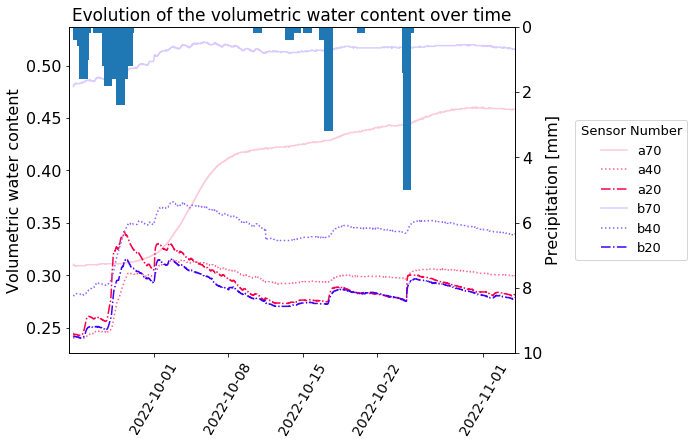

In [63]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2022,11,4)
ftsz=16

fig, ax= plt.subplots(figsize=(8,6))
axb=ax.twinx()

ax.plot(Timestamp, a70, label='a70', color='#fccad8')
ax.plot(Timestamp, a40, label='a40', color='#fc6590', linestyle = 'dotted')
ax.plot(Timestamp, a20, label='a20', color='#fc0048', linestyle = 'dashdot')
ax.plot(Timestamp, b70, label='b70', color='#d8ccff')
ax.plot(Timestamp, b40, label='b40', color ='#8a66ff', linestyle = 'dotted')
ax.plot(Timestamp, b20, label='b20', color='#3c00ff', linestyle = 'dashdot')
ax.set_title('Evolution of the volumetric water content over time', fontsize = ftsz+1)
ax.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.40, 0.5), loc='center right', fontsize=ftsz-3)
ax.set_ylabel('Volumetric water content', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)
axb.bar(clim['date_time'],clim.precipitation)
axb.set_ylim([0, 10])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

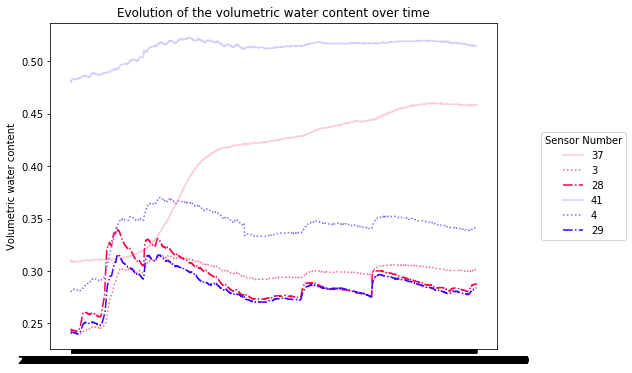

In [18]:

plt.figure(figsize=(8,6))
plt.plot(Timestamp, s37, label='37', color='#fccad8')
plt.plot(Timestamp, s3, label='3', color='#fc6590', linestyle = 'dotted')
plt.plot(Timestamp, s28, label='28', color='#fc0048', linestyle = 'dashdot')
plt.plot(Timestamp, s41, label='41', color='#d8ccff')
plt.plot(Timestamp, s4, label='4', color ='#8a66ff', linestyle = 'dotted')
plt.plot(Timestamp, s29, label='29', color='#3c00ff', linestyle = 'dashdot')
plt.title('Evolution of the volumetric water content over time')
plt.ylabel('Volumetric water content')
plt.xlabel('')
plt.legend(title='Sensor Number', bbox_to_anchor = (1.30, 0.5), loc='center right')


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

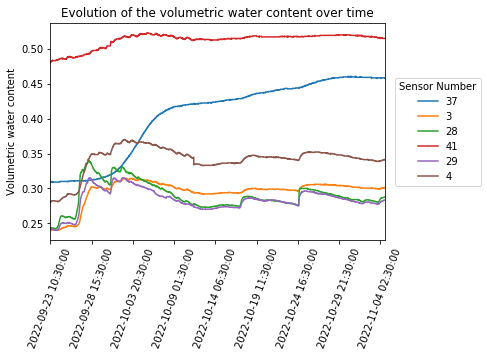

In [19]:
Plotdata1.plot(x='TIMESTAMP')
plt.title('Evolution of the volumetric water content over time')
plt.ylabel('Volumetric water content')
plt.xlabel('')
plt.legend(title='Sensor Number', bbox_to_anchor = (1.30, 0.5), loc='center right')
plt.xticks(rotation = 70)

137     2022-09-23 10:30:00
138     2022-09-23 11:00:00
139     2022-09-23 11:30:00
140     2022-09-23 12:00:00
141     2022-09-23 12:30:00
               ...         
2162    2022-11-04 15:00:00
2163    2022-11-04 15:30:00
2164    2022-11-04 16:00:00
2165    2022-11-04 16:30:00
2166    2022-11-04 17:00:00
Name: TIMESTAMP, Length: 2030, dtype: object
0     2022-09-23 00:00:00
1     2022-09-23 01:00:00
2     2022-09-23 02:00:00
3     2022-09-23 03:00:00
4     2022-09-23 04:00:00
              ...        
596   2022-10-17 20:00:00
597   2022-10-17 21:00:00
598   2022-10-17 22:00:00
599   2022-10-17 23:00:00
600   2022-10-18 00:00:00
Name: date_time, Length: 601, dtype: datetime64[ns]


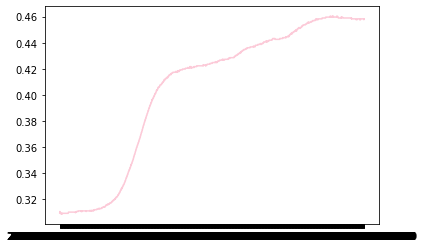

In [27]:
plt.plot(Timestamp, s37, label='37', color='#fccad8')
axb.bar(clim['date_time'],clim.precipitation)
print(Timestamp)
print(clim['date_time'])